# Compare marginal vs Knockoff analysis for 15 UKB phenotypes

+ Groups defined via average linkage hierarchical clustering
+ When importing $\Sigma$ to solve knockoff problem, we make smallest eigenvalue $1e-5$ by computing eigendecomposition
+ We use sum of group-wise feature statistics

In [1]:
using RCall
using CSV
using DataFrames
using Suppressor
R"library(CMplot)"

# this function makes 2 manhattan plot, one for marginal analysis one for knockoff analysis
function make_manhattan(outfile::String, plot_title::String; 
    pval_min=1e-100, maxW=0.1, target_fdr=0.1, add_chrom_density::Bool=false,
    label_snps=true
    )
    result = CSV.read(outfile, DataFrame)
    pheno_name = basename(outfile)[1:end-4] # no .txt

    #
    # Manhattan plot for marginal analysis
    #
    # find most significant SNP within blocks of 1Mb
    Mb = 1e6
    label_idx = Int[]
    for chr in 1:22
        chr_idx = findall(x -> x == chr, result[!, "chr"])
        pos = result[chr_idx, :pos_hg19]
        blocks = div.(pos, Mb)
        for block in unique(blocks)
            block_idx = findall(x -> x == block, blocks)
            pvals = result[chr_idx[block_idx], :pvals]
            pval, pval_idx = findmin(pvals)
            if pval < 5e-8
                push!(label_idx, chr_idx[block_idx[pval_idx]])
            end
        end
    end

    # label significant SNPs
    signif_snps = result[label_idx, :rsid]
    println("Marginal analysis found $(length(signif_snps)) independent SNPs")
    
    # get dataframe into format that CMplot requires
    df = result[!, [:rsid, :chr, :pos_hg38, :pvals]]
    df[findall(x -> x < pval_min, df[!, :pvals]), :pvals] .= pval_min

    # use CMplot in R to make manhattan
    marginal_title = plot_title * " via conventional marginal association test"
    marginal_outfile = pheno_name * ".marginal"
    @rput df pheno_name signif_snps marginal_title marginal_outfile add_chrom_density
    @suppress begin
        if label_snps
            R"""
            if(add_chrom_density){
                CMplot(df,type="p",plot.type="m", main=marginal_title,
                highlight=signif_snps,highlight.text=signif_snps,highlight.cex=1, 
                col=c("grey30","grey60"), threshold=5e-8,
                LOG10=TRUE,file="jpg",file.name=marginal_outfile,dpi=300,
                file.output=TRUE,verbose=TRUE,width=14,height=6,
                chr.den.col=c("darkgreen", "yellow", "red"), bin.range=c(0,500))
            } else {
                CMplot(df,type="p",plot.type="m", main=marginal_title,
                highlight=signif_snps,highlight.text=signif_snps,highlight.cex=1, 
                col=c("grey30","grey60"), threshold=5e-8,
                LOG10=TRUE,file="jpg",file.name=marginal_outfile,dpi=300,
                file.output=TRUE,verbose=TRUE,width=14,height=6)
            }
            """
        else
            R"""
            if(add_chrom_density){
                CMplot(df,type="p",plot.type="m", main=marginal_title,
                col=c("grey30","grey60"), threshold=5e-8,
                LOG10=TRUE,file="jpg",file.name=marginal_outfile,dpi=300,
                file.output=TRUE,verbose=TRUE,width=14,height=6,
                chr.den.col=c("darkgreen", "yellow", "red"), bin.range=c(0,500))
            } else {
                CMplot(df,type="p",plot.type="m", main=marginal_title,
                col=c("grey30","grey60"), threshold=5e-8,
                LOG10=TRUE,file="jpg",file.name=marginal_outfile,dpi=300,
                file.output=TRUE,verbose=TRUE,width=14,height=6)
            }
            """
        end
    end

    #
    # Manhattan plot for knockoff analysis
    # 
    summary = CSV.read(joinpath(dirname(outfile), pheno_name * "_summary.txt"), DataFrame, header=false)
    if target_fdr == 0.05
        q = summary[3, 2] # target FDR 0.05
    elseif target_fdr == 0.1
        q = summary[5, 2] # target FDR 0.1
    elseif target_fdr == 0.2
        q = summary[9, 2] # target FDR 0.2
    end

    # clamp large W statistics to produce prettier plot
    result[findall(x -> x ≥ maxW, result[!, :W]), :W] .= maxW

    # optional: plot only W ≥ 0
    result = result[findall(x -> x > 0, result[!, :W]), :]

    # for each group, only keep SNP with largest Z score
    keep_idx = Int[]
    for g in unique(result[!, "group"])
        idx = findall(x -> x == g, result[!, "group"])
        zscores = result[idx, "zscores"]
        z, z_idx = findmax(abs.(zscores))
        push!(keep_idx, idx[z_idx])
    end
    result = result[keep_idx, :]

    # find most significant SNP within blocks of 1Mb
    Mb = 1e6
    label_idx = Int[]
    result[!, "gene"] = ["" for i in 1:size(result, 1)]
    for chr in 1:22
        chr_idx = findall(x -> x == chr, result[!, "chr"])
        pos = result[chr_idx, :pos_hg19]
        blocks = div.(pos, Mb)
        for block in unique(blocks)
            block_idx = findall(x -> x == block, blocks)
            Ws = result[chr_idx[block_idx], :W]
            w, w_idx = findmax(Ws)
            if w > q
                push!(label_idx, chr_idx[block_idx[w_idx]])
            end
        end
    end

    # label significant SNPs
    signif_snps = result[label_idx, :rsid]
    println("Knockoff analysis found $(length(signif_snps)) independent SNPs")
    println("Number of regions successfully used = $(summary[12, 2])")
    println("Number of SNPs used in analysis = $(summary[13, 2])")

    # get dataframe into format that CMplot requires
    df = result[!, [:rsid, :chr, :pos_hg38, :W]]

    # use CMplot in R to make manhattan
    knockoff_title = plot_title * " via Group Knockoff conditional independence test"
    knockoff_outfile = pheno_name * ".knockoff"
    @rput df outfile signif_snps q maxW knockoff_title knockoff_outfile
    @suppress begin
        if label_snps
            R"""
            if(add_chrom_density){
                CMplot(df,type="p",plot.type="m",LOG10=FALSE, ylab="W", ylim=c(0, maxW),
                main=knockoff_title,
                highlight=signif_snps,highlight.text=signif_snps,highlight.cex=1, 
                col=c("grey30","grey60"), threshold=q,
                file="jpg",file.name=knockoff_outfile,dpi=300,
                file.output=TRUE,verbose=TRUE,width=14,height=6,
                chr.den.col=c("darkgreen", "yellow", "red"), bin.range=c(0,5))
            } else {
                CMplot(df,type="p",plot.type="m",LOG10=FALSE, ylab="W", ylim=c(0, maxW),
                main=knockoff_title,
                highlight=signif_snps,highlight.text=signif_snps,highlight.cex=1, 
                col=c("grey30","grey60"), threshold=q,
                file="jpg",file.name=knockoff_outfile,dpi=300,
                file.output=TRUE,verbose=TRUE,width=14,height=6)
            }
            """
        else
            R"""
            if(add_chrom_density){
                CMplot(df,type="p",plot.type="m",LOG10=FALSE, ylab="W", ylim=c(0, maxW),
                main=knockoff_title, col=c("grey30","grey60"), threshold=q,
                file="jpg",file.name=knockoff_outfile,dpi=300,
                file.output=TRUE,verbose=TRUE,width=14,height=6,
                chr.den.col=c("darkgreen", "yellow", "red"), bin.range=c(0,5))
            } else {
                CMplot(df,type="p",plot.type="m",LOG10=FALSE, ylab="W", ylim=c(0, maxW),
                main=knockoff_title, col=c("grey30","grey60"), threshold=q,
                file="jpg",file.name=knockoff_outfile,dpi=300,
                file.output=TRUE,verbose=TRUE,width=14,height=6)
            }
            """
        end
    end
end

function summary_result(outfile::String, target_fdr=0.1)
    result = CSV.read(outfile, DataFrame)
    pheno_name = basename(outfile)[1:end-4] # no .txt

    #
    # Manhattan plot for marginal analysis
    #
    # find most significant SNP within blocks of 1Mb
    Mb = 1e6
    label_idx = Int[]
    for chr in 1:22
        chr_idx = findall(x -> x == chr, result[!, "chr"])
        pos = result[chr_idx, :pos_hg19]
        blocks = div.(pos, Mb)
        for block in unique(blocks)
            block_idx = findall(x -> x == block, blocks)
            pvals = result[chr_idx[block_idx], :pvals]
            pval, pval_idx = findmin(pvals)
            if pval < 5e-8
                push!(label_idx, chr_idx[block_idx[pval_idx]])
            end
        end
    end

    # label significant SNPs
    marginal_signif_snps = length(result[label_idx, :rsid])
    
    # get dataframe into format that CMplot requires
    df = result[!, [:rsid, :chr, :pos_hg38, :pvals]]

    #
    # Manhattan plot for knockoff analysis
    # 
    summary = CSV.read(joinpath(dirname(outfile), pheno_name * "_summary.txt"), DataFrame, header=false)
    if target_fdr == 0.05
        q = summary[3, 2] # target FDR 0.05
    elseif target_fdr == 0.1
        q = summary[5, 2] # target FDR 0.1
    elseif target_fdr == 0.2
        q = summary[9, 2] # target FDR 0.2
    end

    # optional: plot only W ≥ 0
    result = result[findall(x -> x > 0, result[!, :W]), :]

    # for each group, only keep SNP with largest Z score
    keep_idx = Int[]
    for g in unique(result[!, "group"])
        idx = findall(x -> x == g, result[!, "group"])
        zscores = result[idx, "zscores"]
        z, z_idx = findmax(abs.(zscores))
        push!(keep_idx, idx[z_idx])
    end
    result = result[keep_idx, :]

    # find most significant SNP within blocks of 1Mb
    Mb = 1e6
    label_idx = Int[]
    result[!, "gene"] = ["" for i in 1:size(result, 1)]
    for chr in 1:22
        chr_idx = findall(x -> x == chr, result[!, "chr"])
        pos = result[chr_idx, :pos_hg19]
        blocks = div.(pos, Mb)
        for block in unique(blocks)
            block_idx = findall(x -> x == block, blocks)
            Ws = result[chr_idx[block_idx], :W]
            w, w_idx = findmax(Ws)
            if w > q
                push!(label_idx, chr_idx[block_idx[w_idx]])
            end
        end
    end

    # knockoff significant SNPs
    ko_signif_snps = length(result[label_idx, :rsid])
    nregions = summary[12, 2]
    nsnps = summary[13, 2]
#     println("Knockoff analysis found $(length(signif_snps)) independent SNPs")
#     println("Number of regions successfully used = $(summary[12, 2])")
#     println("Number of SNPs used in analysis = $(summary[13, 2])")
    
    return marginal_signif_snps, ko_signif_snps, nregions, nsnps
end

┌ Warning: RCall.jl: Much appreciate for using CMplot.
│ Full description, Bug report, Suggestion and the latest codes:
│ https://github.com/YinLiLin/CMplot
└ @ RCall /home/groups/sabatti/.julia/packages/RCall/LWzAQ/src/io.jl:172


summary_result (generic function with 2 methods)

## Albuminuria GWAS

Marginal analysis found 28 independent SNPs
Knockoff analysis found 35 independent SNPs
Number of regions successfully used = 1702.0
Number of SNPs used in analysis = 630017.0


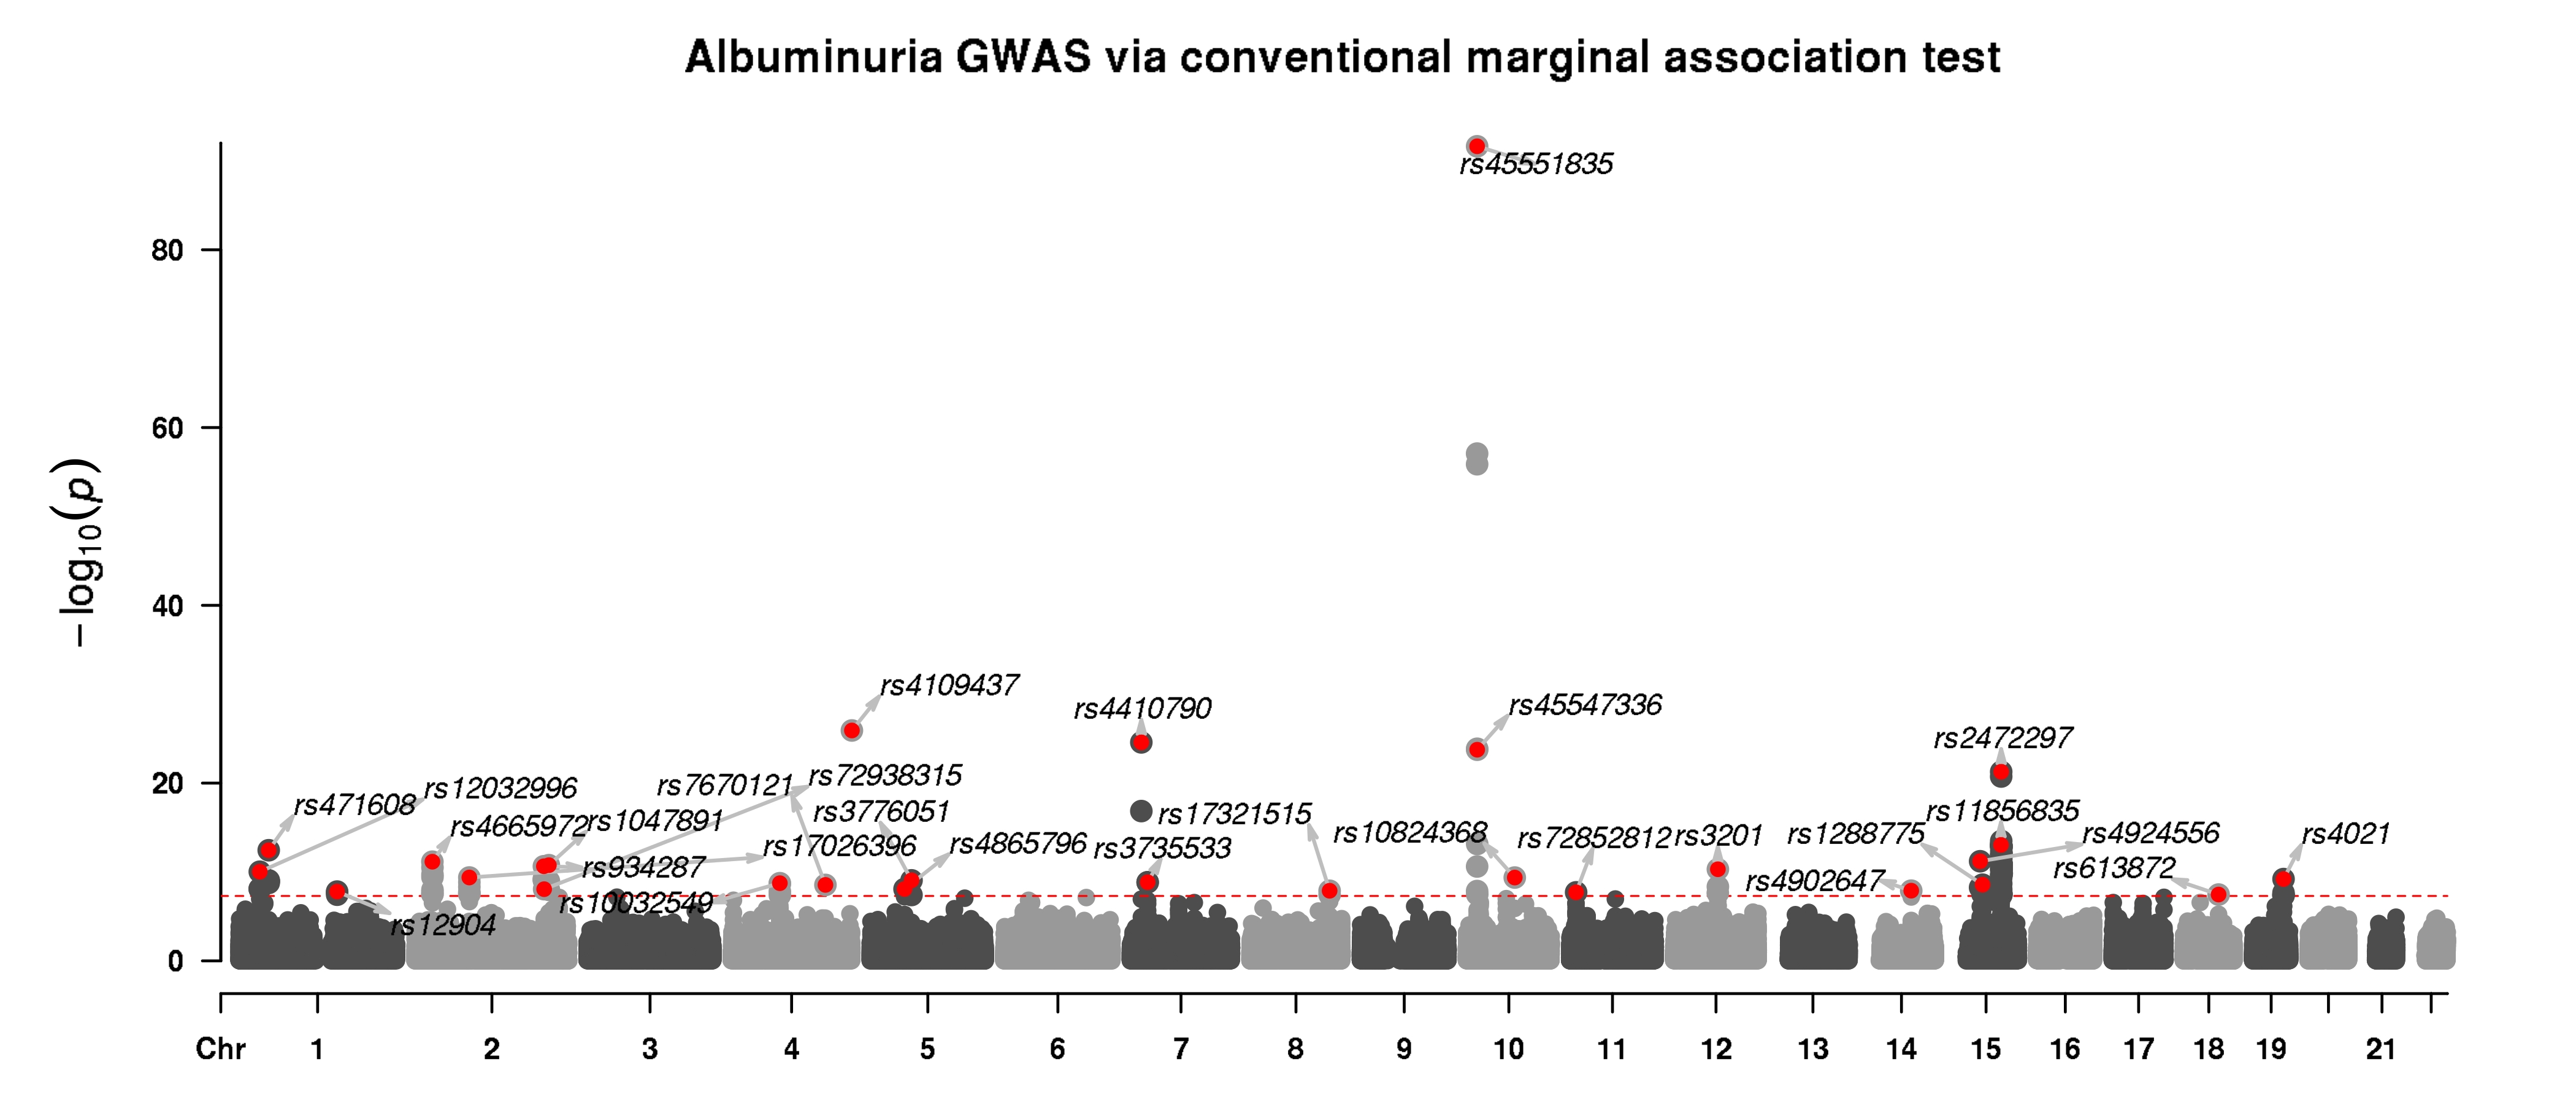

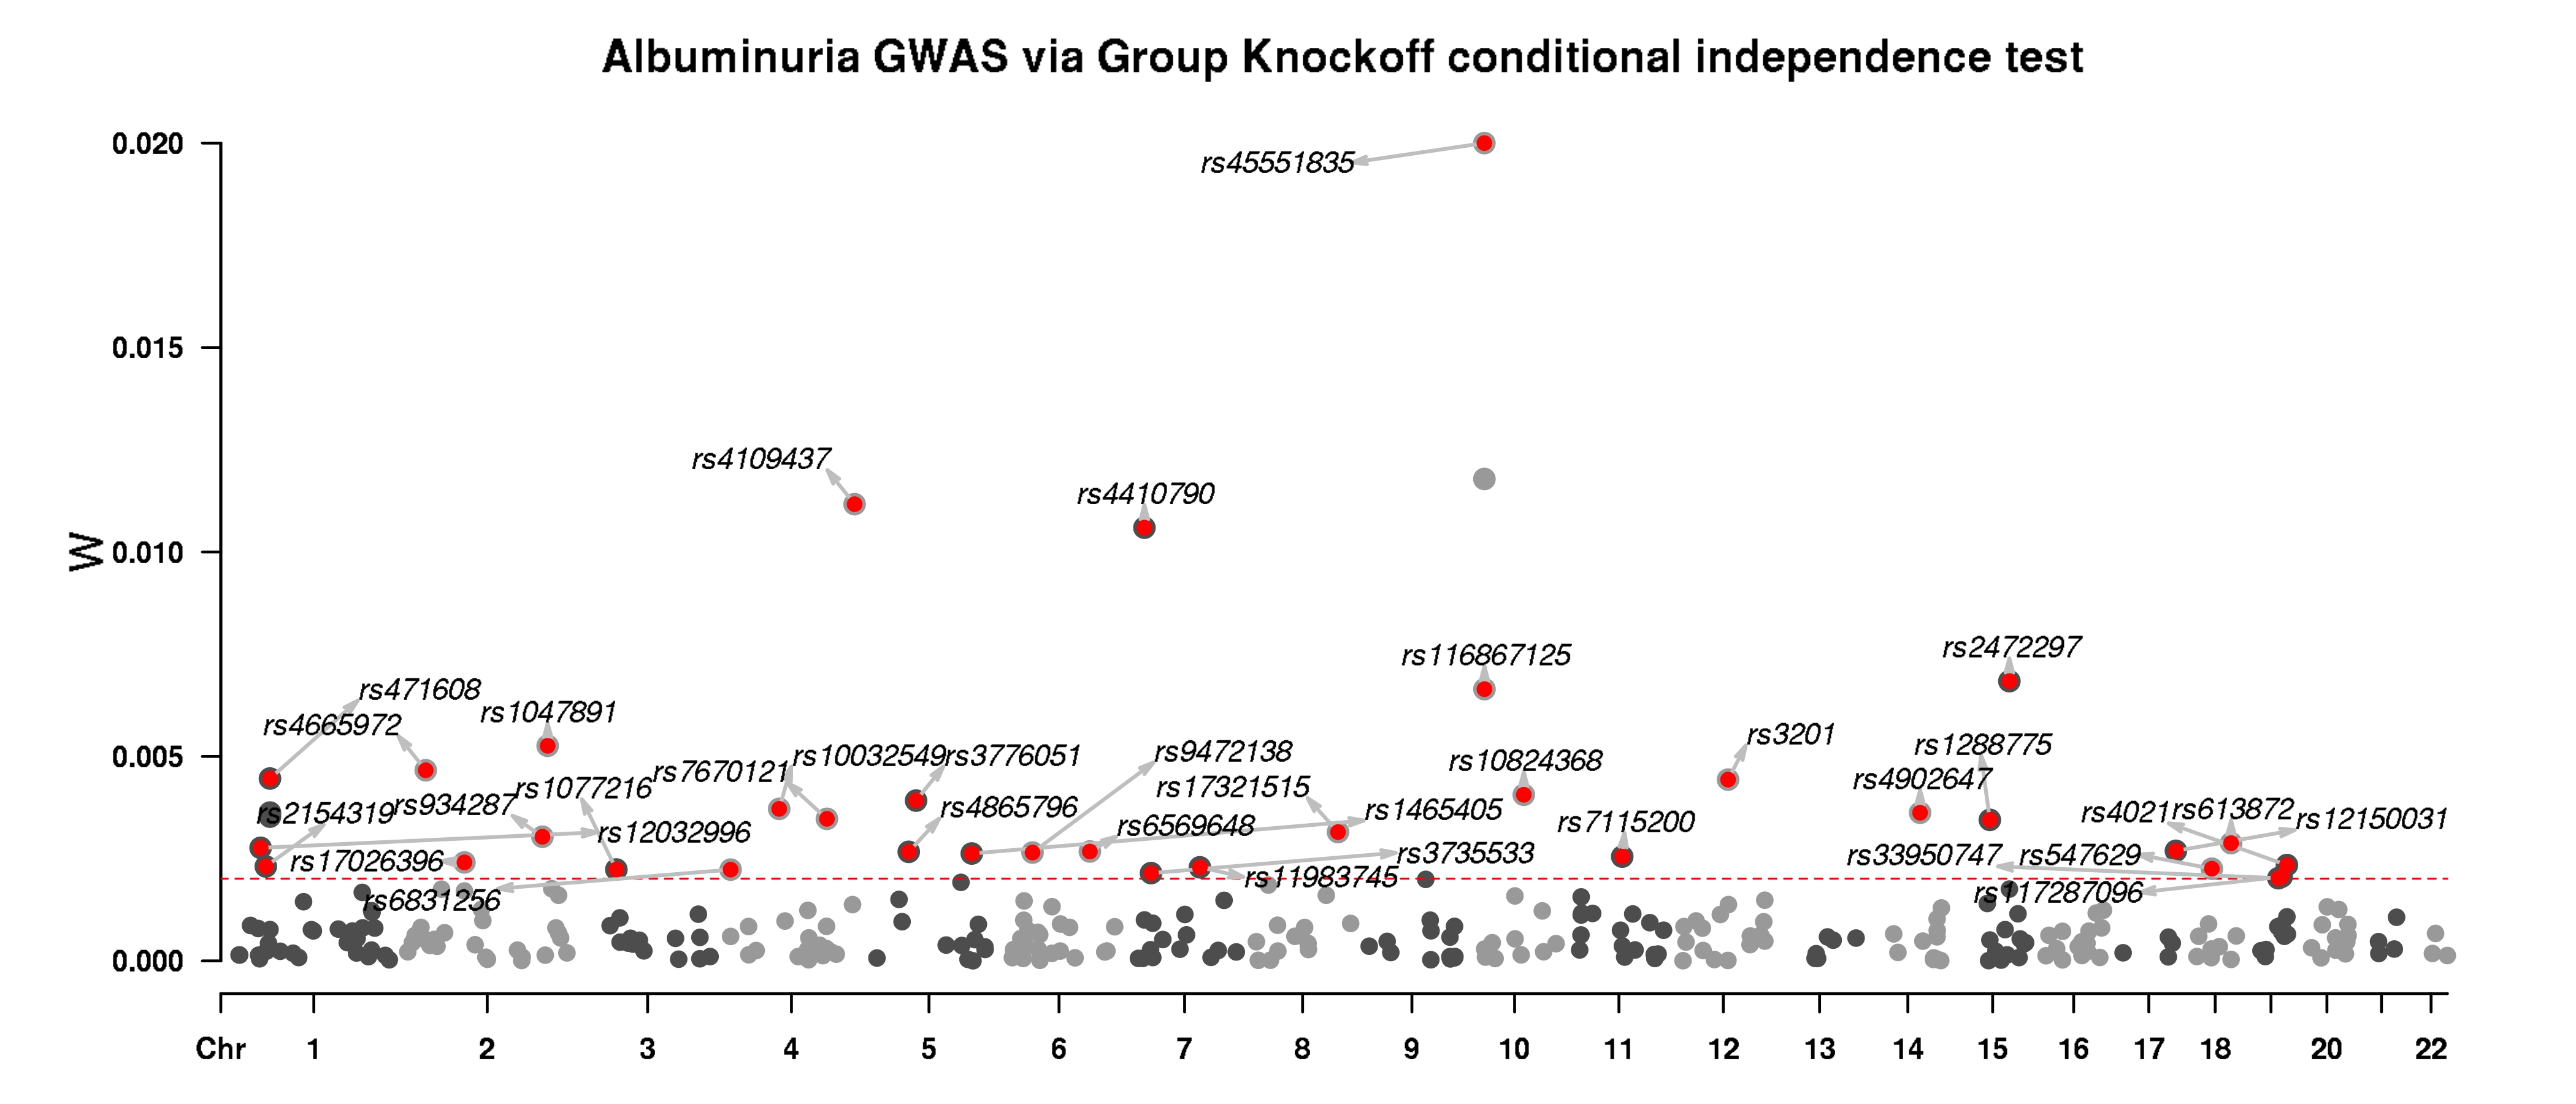

In [4]:
# make plot
outfile = "/oak/stanford/groups/zihuai/pan_ukb_group_knockoffs/results/albuminuria_maxent_hc_seed1.txt"
plot_title = "Albuminuria GWAS"
make_manhattan(outfile, plot_title, maxW=0.02)

# display plots
display("image/png", read("Rect_Manhtn.albuminuria_maxent_hc_seed1.marginal.jpg"))
display("image/png", read("Rect_Manhtn.albuminuria_maxent_hc_seed1.knockoff.jpg"))